### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 1


### Дисциплина: Методы машинного обучения

##### Студент:  Матюхин Григорий Васильевич
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №7

1. Набор данных: efron_morris75 
2. Независимая переменная: RemainingAverage 
3. Зависимая переменная: SeasonAverage 
4. Визуализация для независимой переменной – диаграмма размаха 
5. Визуализация для зависимой переменной – эмпирическая функция распределения 
6. Показатель качества регрессии – R^2 (коэффициент детерминации) 


# Выполнение

## Шаг 1: Загружаем датасет

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

2024-04-19 04:15:34.958324: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 04:15:34.961264: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-19 04:15:35.010243: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 04:15:35.913870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ds = tfds.load("efron_morris75", split="train")
df = tfds.as_dataframe(ds)
len(df)

2024-04-19 04:15:37.247642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18

In [3]:
df.head()

,At-Bats,BattingAverage,FirstName,Hits,LastName,RemainingAt-Bats,RemainingAverage,SeasonAt-Bats,SeasonAverage,SeasonHits
0,45,0.289,b'Don',13,b'Kessinger',586,0.2645,631,0.266,168
1,45,0.178,b'Thurman',8,b'Munson',408,0.3162,453,0.302,137
2,45,0.222,b'George',10,b'Scott',435,0.3034,480,0.296,142
3,45,0.222,b'Billy',10,b'Williams',591,0.3299,636,0.251,205
4,45,0.311,b'Jim',14,b'Spencer',466,0.2704,511,0.274,140


Оставляем только признаки, принимающие непрерывные числовые значения

In [4]:
df.drop(columns=["FirstName", "LastName", "At-Bats", "Hits", "SeasonAt-Bats", "SeasonHits", "RemainingAt-Bats"], inplace=True)
df.head()

,BattingAverage,RemainingAverage,SeasonAverage
0,0.289,0.2645,0.266
1,0.178,0.3162,0.302
2,0.222,0.3034,0.296
3,0.222,0.3299,0.251
4,0.311,0.2704,0.274


### Анализ датасета

In [5]:
import pandas as pd

In [6]:
corr=df.corr()
corr

,BattingAverage,RemainingAverage,SeasonAverage
BattingAverage,1.000000,0.261038,0.534403
RemainingAverage,0.261038,1.000000,0.865239
SeasonAverage,0.534403,0.865239,1.000000


In [7]:
a, b = corr.stack().idxmin()
print("Min correlation:\n", corr.loc[[a], [b]])

Min correlation:
                 RemainingAverage
BattingAverage          0.261038


In [8]:
corr = corr.stack()
corr = corr[corr != 1.0]
a, b = corr.idxmax()
print("Max correlation:\n", corr.loc[[a], [b]])

Max correlation:
 RemainingAverage  SeasonAverage    0.865239
dtype: float64


## Шаг 2: Визуализация данных

<Axes: title={'center': 'Диаграмма размаха для RemainingAverage'}>

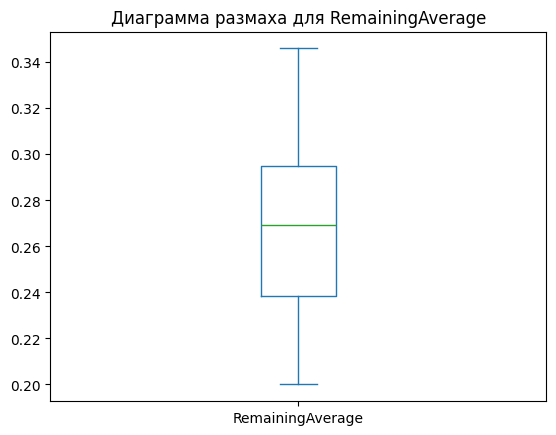

In [9]:
df["RemainingAverage"].plot.box(title="Диаграмма размаха для RemainingAverage")

### Считаем эмпирическую функцию распределения для SeasonAverage

In [10]:
import numpy as np

<Axes: title={'center': 'ECDF'}>

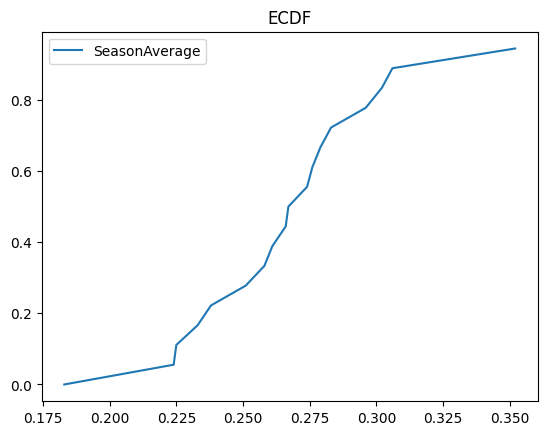

In [11]:
tx = np.sort(df["SeasonAverage"])
ty = np.arange(len(tx))/float(len(tx))
ecdf = pd.DataFrame(ty, index=tx, columns=["SeasonAverage"])
ecdf.plot.line(title="ECDF")

## Шаг 3: Диаграмма рассеяния

<Axes: title={'center': 'Диаграмма рассеяния для RemainingAverage и SeasonAverage'}, xlabel='RemainingAverage', ylabel='SeasonAverage'>

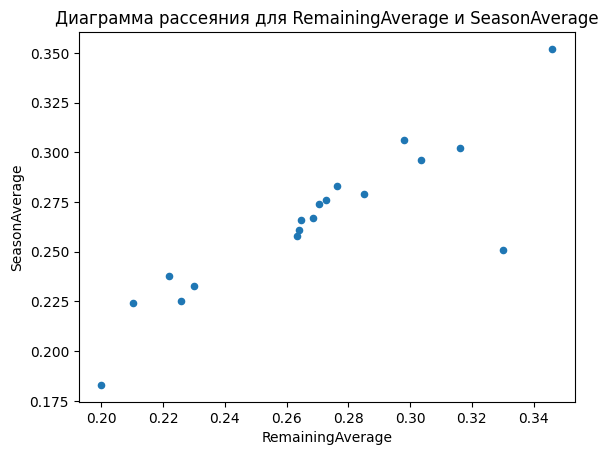

In [12]:
df.plot.scatter("RemainingAverage", "SeasonAverage", title="Диаграмма рассеяния для RemainingAverage и SeasonAverage")

### Убираем одинокие точки

In [13]:
sorted_y = np.sort(df.RemainingAverage)
second_max = sorted_y[-2]
df = df[df.RemainingAverage != second_max]

<Axes: title={'center': 'Диаграмма рассеяния для RemainingAverage и SeasonAverage'}, xlabel='RemainingAverage', ylabel='SeasonAverage'>

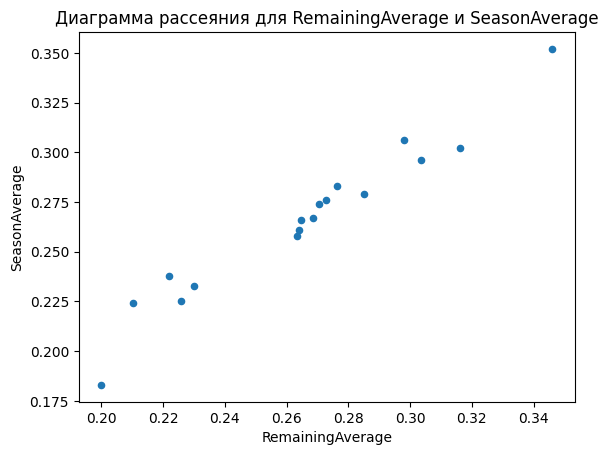

In [14]:
df.plot.scatter("RemainingAverage", "SeasonAverage", title="Диаграмма рассеяния для RemainingAverage и SeasonAverage")

## Шаг 4: Линейная регрессия

### Точный подход

In [15]:
class SimpleLinReg:
    def __init__(self):
        self._a = None
        self._b = None
    def fit(self, x, y):
        x_mean = np.mean(x)
        y_mean = np.mean(y)
        tx = x - x_mean
        ty = y - y_mean
        self._a = tx.dot(ty) / tx.dot(tx)
        self._b = y_mean - self._a * x_mean
        return self
    def predict(self, x_predict):
        return np.array([self._predict(x) for x in x_predict])
    def _predict(self, x_single):
        return self._a * x_single + self._b
    def __repr__(self):
        return "SimpleLinReg()"

In [16]:
x = df.RemainingAverage
y = df.SeasonAverage

In [17]:
reg = SimpleLinReg()
reg.fit(x, y)
pred = reg.predict(np.array(x))
pred

array([0.26492736, 0.3151513 , 0.3027168 , 0.2706589 , 0.26395592,
       0.28474495, 0.27289328, 0.2643445 , 0.20226885, 0.34410053,
       0.26891032, 0.22344646, 0.29756808, 0.23141235, 0.2120805 ,
       0.22733225, 0.27648762], dtype=float32)

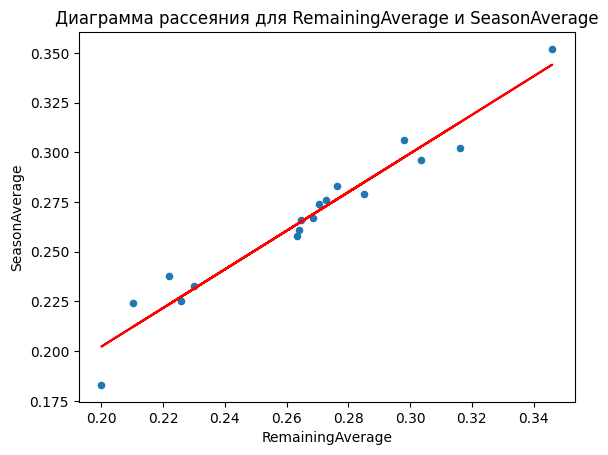

In [18]:
plt = df.plot.scatter("RemainingAverage", "SeasonAverage", title="Диаграмма рассеяния для RemainingAverage и SeasonAverage")
plt.plot(x, pred, color="r")

In [19]:
mse = np.sum((pred - y) ** 2) / len(y)
print("Mean square error: ", mse)

Mean square error:  7.24934644120581e-05


In [20]:
r2 = 1 - mse/np.var(y)
print("R^2:", r2)

R^2: 0.9488867321643357


### Нейронная сеть с одним нейроном

In [21]:
model = tf.keras.Sequential([tf.keras.layers.Input((1,)), tf.keras.layers.Dense(1)])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

In [23]:
model.fit(x, y, epochs=500, verbose=0)

In [24]:
model_predict = model.predict(x)
model_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[0.26233995],
       [0.31262493],
       [0.3001753 ],
       [0.26807848],
       [0.26136735],
       [0.28218162],
       [0.27031553],
       [0.2617564 ],
       [0.19960532],
       [0.34160933],
       [0.26632774],
       [0.22080866],
       [0.29502034],
       [0.22878423],
       [0.20942888],
       [0.22469917],
       [0.27391428]], dtype=float32)

In [25]:
_, model_r2 = model.evaluate(x, y)
print("R^2 нейронной сети:", model_r2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0071 - r2_score: 0.9442
R^2 нейронной сети: 0.944170355796814


In [26]:
print("Точный метод: ", r2, "\nНейронная сеть: ", model_r2)

Точный метод:  0.9488867321643357 
Нейронная сеть:  0.944170355796814


## Шаг 5: Сравнение на диаграмме рассеяния

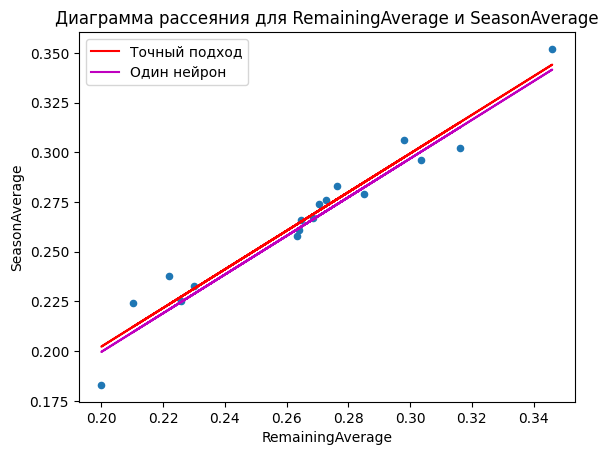

In [27]:
plt = df.plot.scatter("RemainingAverage", "SeasonAverage", title="Диаграмма рассеяния для RemainingAverage и SeasonAverage")
plt.plot(x, pred, color="r", label="Точный подход")
plt.plot(x, model_predict, color="m", label="Один нейрон")
plt.legend()

## Шаг 6: Разбиение и нормализация

### Разбиение

In [28]:
split = 0.8
df = df.sample(frac=1)
idx = int(len(df) * split)
train, test = df[:idx], df[idx:]
len(train), len(test)

(13, 4)

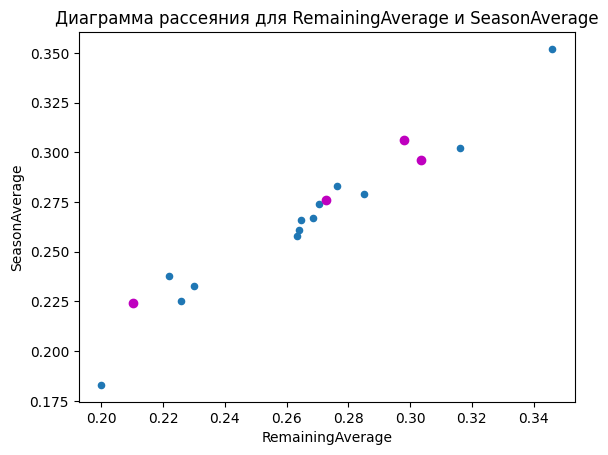

In [29]:
plt = train.plot.scatter("RemainingAverage", "SeasonAverage", title="Диаграмма рассеяния для RemainingAverage и SeasonAverage")
plt.scatter(test["RemainingAverage"], test["SeasonAverage"], color="m")

### Нормализация методами Tensorflow

In [30]:
feature_labels = np.array([x for x in train if x != "SeasonAverage"])
features = train[feature_labels]
np_features = np.array(features)
np_features.shape

(13, 2)

In [31]:
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np_features)

In [32]:
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[[0.25976923 0.264     ]]
[[0.00489002 0.00143032]]


### Нормализация зависимого признака вручную

In [33]:
y_train = np.array(train["SeasonAverage"])
y_train_std = (y_train - y_train.mean()) / y_train.std()
y_train_std.mean(), y_train_std.std()

(-2.1549371e-07, 1.0)

In [34]:
x_test = np.array(test[feature_labels])
x_test.shape

(4, 2)

In [35]:
y_test = np.array(test["SeasonAverage"])
y_test_std = (y_test - y_test.mean()) / y_test.std()
y_test_std.mean(), y_test_std.std()

(0.0, 1.0)

## Шаг 7: Несколько регрессоров

### Линейная регрессия

In [36]:
input_layer = tf.keras.layers.Input(np_features[0].shape)

In [37]:
linear_model = tf.keras.Sequential([
    input_layer,
    normalizer,
    tf.keras.layers.Dense(1)
])
linear_model.name = "linear_model"
linear_model.summary()

Model: "linear_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

In [38]:
linear_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

In [39]:
l_hist = linear_model.fit(features, y_train_std, epochs=1000, validation_split=0.2, verbose=0)

### Лассо регрессии (L1)

In [40]:
l1_model = tf.keras.Sequential([
    input_layer,
    normalizer,
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L1(l1=0.02))
])
l1_model.name = "l1_model"
l1_model.summary()

Model: "l1_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

In [41]:
l1_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

In [42]:
l1_hist = l1_model.fit(features, y_train_std, epochs=1000, validation_split=0.2, verbose=0)

### Гребневая регрессия (L2)

In [43]:
l2_model = tf.keras.Sequential([
    input_layer,
    normalizer,
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.L2(l2=0.02))
])
l2_model.name = "l2_model"
l2_model.summary()

Model: "l2_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

In [44]:
l2_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

In [45]:
l2_hist = l2_model.fit(features, y_train_std, epochs=1000, validation_split=0.2, verbose=0)

## Шаг 8: Сравнение

In [46]:
models = {
    linear_model.name: (linear_model, l_hist),
    l1_model.name: (l1_model, l1_hist),
    l2_model.name: (l2_model, l2_hist)
}
scores = dict()
for name, (m, h) in models.items():
    _, r2 = m.evaluate(x_test, y_test_std)
    scores[name] = r2

best_model_name = max(list(scores), key=lambda x: scores[x])
best_model = models[best_model_name][0]
best_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2531 - r2_score: 0.9276
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2550 - r2_score: 0.9337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2652 - r2_score: 0.9277


Model: "l1_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16 (72.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

 Optimizer params: 8 (36.00 B)

## Шаг 9: Визуализация лучшей модели

In [47]:
import matplotlib.pyplot as plt

In [48]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, max(history.history['loss']) * 0.5])
    plt.xlabel("Эпохи обучения")
    plt.ylabel("Ошибка")
    plt.legend()
    plt.grid(True)

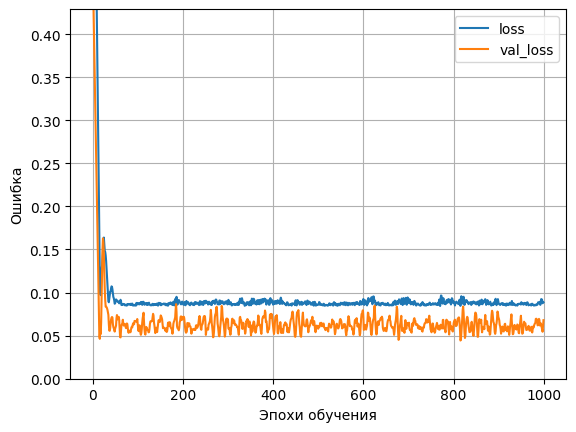

In [49]:
plot_loss(models[best_model_name][1])

## Шаг 10

In [50]:
from mpl_toolkits.mplot3d import Axes3D

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


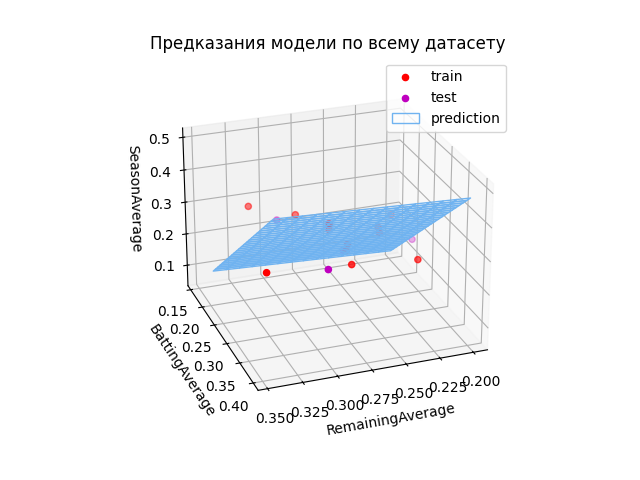

In [54]:
%matplotlib widget
plt.style.use("default")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlabel("RemainingAverage")
ax.set_ylabel("BattingAverage")
ax.set_zlabel("SeasonAverage")

x_train = train["RemainingAverage"]
y_train = train["BattingAverage"]
z_train = train["SeasonAverage"]
ax.scatter(x_train, y_train, z_train, color="r", label="train")

x_test = test["RemainingAverage"]
y_test = test["BattingAverage"]
z_test = test["SeasonAverage"]
ax.scatter(x_test, y_test, z_test, color="m", label="test")

x = np.arange(min(x_train), max(x_train), 0.01)
y = np.arange(min(y_train), max(y_train), 0.01)
X,Y = np.meshgrid(x, y)

points = np.array(list(zip(np.ravel(X), np.ravel(Y))))
Z = best_model.predict(points)
Z = Z.reshape(X.shape)
std = y_train.std()
mean = y_train.mean()
Z = (Z * std) + mean

ax.plot_surface(X, Y, Z, facecolor=(0,0,0,0), edgecolor='#70b3f0', label="prediction")
ax.set_title("Предказания модели по всему датасету")
ax.legend()

ax.view_init(elev=25, azim=70)